In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import torch
import numpy as np

knock70

In [3]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [69]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors

d = 300
L = 4

def preprc(data):
  x = []
  y = []
  label = {"b":0, "e":2, "t":1, "m":3} #ビジネス:0, エンターテインメント:2, 科学技術:1, 健康:3
  for l in data:
    da = l.split("\t")
    # titleを数字をすべて0、アルファベットを小文字にする
    xd = [i.rstrip("\n").strip(":'$%?,.()!;").strip('"') for i in re.sub("[0-9]+", "0", da[1]).lower().split(" ") if i != "" and i != "...\n"]
    emb_sum = torch.zeros((d,))
    nd = 0
    for w in xd:
      if not w in model.key_to_index:
        nd += 1
        #print(w)
      else:
        emb_sum += torch.from_numpy(model[w])
    if (len(xd) - nd) != 0:
      x.append(emb_sum / (len(xd) - nd))
      y.append(label[da[0]])
  return torch.stack(x), torch.tensor(y)

train = []
valid = []
test = []
with open('/content/drive/MyDrive/train.txt', encoding='utf-8') as f:
  for l in f:
    train.append(l)
with open('/content/drive/MyDrive/valid.txt', encoding='utf-8') as f:
  for l in f:
    valid.append(l)
with open('/content/drive/MyDrive/test.txt', encoding='utf-8') as f:
  for l in f:
    test.append(l)
X_train, Y_train = preprc(train)
X_valid, Y_valid = preprc(valid)
X_test, Y_test = preprc(test)

In [70]:
np.save('/content/drive/MyDrive/X_train.npy', X_train.numpy())
np.save('/content/drive/MyDrive/Y_train.npy', Y_train.numpy())
np.save('/content/drive/MyDrive/X_valid.npy', X_valid.numpy())
np.save('/content/drive/MyDrive/Y_valid.npy', Y_valid.numpy())
np.save('/content/drive/MyDrive/X_test.npy', X_test.numpy())
np.save('/content/drive/MyDrive/Y_test.npy', Y_test.numpy())

knock71

In [71]:
def read_f():
  X_train = torch.from_numpy(np.load('/content/drive/MyDrive/X_train.npy'))
  Y_train = torch.from_numpy(np.load('/content/drive/MyDrive/Y_train.npy'))
  X_valid = torch.from_numpy(np.load('/content/drive/MyDrive/X_valid.npy'))
  Y_valid = torch.from_numpy(np.load('/content/drive/MyDrive/Y_valid.npy'))
  X_test = torch.from_numpy(np.load('/content/drive/MyDrive/X_test.npy'))
  Y_test = torch.from_numpy(np.load('/content/drive/MyDrive/Y_test.npy'))
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = read_f()
W = torch.randn(d, L, requires_grad=True)

In [72]:
yh1 = torch.softmax(X_train[0] @ W, dim=-1)
Yh = torch.softmax(X_train[:4] @ W, dim=-1)
print(f"{yh1}")
print(f"{Yh}")

tensor([0.0590, 0.7854, 0.0361, 0.1195], grad_fn=<SoftmaxBackward0>)
tensor([[0.0590, 0.7854, 0.0361, 0.1195],
        [0.0566, 0.0984, 0.3531, 0.4919],
        [0.4042, 0.4901, 0.0569, 0.0488],
        [0.7679, 0.1681, 0.0256, 0.0384]], grad_fn=<SoftmaxBackward0>)


knock72

In [75]:
from torch import nn

class SLPN(nn.Module):
  def __init__(self, ins, outs):
    super().__init__()
    self.fc = nn.Linear(ins, outs, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)
  def forward(self, x):
    return self.fc(x)

n_W = SLPN(d, L)

criterion = torch.nn.CrossEntropyLoss()
l1 = criterion(n_W(X_train[0]), Y_train[0])
n_W.zero_grad()
l1.backward()
print(f"x1のクロスエントロピー損失：{l1}")
print(f"x1の行列Wに対する勾配：\n{n_W.fc.weight.grad}")
l = criterion(n_W(X_train[:4]), Y_train[:4])
n_W.zero_grad()
l.backward()
print(f"\n事例集合x1,x2,x3,x4のクロスエントロピー損失：{l}")
print(f"事例集合x1,x2,x3,x4の行列Wに対する勾配：\n{n_W.fc.weight.grad}")

x1のクロスエントロピー損失：0.9755285382270813
x1の行列Wに対する勾配：
tensor([[-8.4388e-04,  1.3782e-03,  4.1367e-06,  ..., -5.2500e-04,
          1.6950e-03,  9.0791e-04],
        [-1.5847e-02,  2.5881e-02,  7.7682e-05,  ..., -9.8588e-03,
          3.1829e-02,  1.7049e-02],
        [ 2.2302e-02, -3.6423e-02, -1.0932e-04,  ...,  1.3874e-02,
         -4.4794e-02, -2.3994e-02],
        [-5.6109e-03,  9.1635e-03,  2.7504e-05,  ..., -3.4907e-03,
          1.1270e-02,  6.0366e-03]])

事例集合x1,x2,x3,x4のクロスエントロピー損失：1.299067497253418
事例集合x1,x2,x3,x4の行列Wに対する勾配：
tensor([[ 0.0042,  0.0151, -0.0033,  ..., -0.0017, -0.0496,  0.0085],
        [-0.0037, -0.0210, -0.0006,  ..., -0.0118,  0.0470,  0.0137],
        [ 0.0122, -0.0099,  0.0072,  ...,  0.0230,  0.0067, -0.0287],
        [-0.0126,  0.0158, -0.0032,  ..., -0.0094, -0.0040,  0.0065]])


knock73

In [76]:
optimizer = torch.optim.SGD(n_W.parameters(), lr=0.1)

for epoch in range(100):
  n_W.train()
  loss_train = 0.0
  for i, nt in enumerate(X_train):
    la = Y_train[i]
    optimizer.zero_grad()
    loss = criterion(n_W(nt), la)
    loss.backward()
    optimizer.step()
    loss_train += loss.item()
  loss_train = loss_train / i
  n_W.eval()
  with torch.no_grad():
    loss_valid = criterion(n_W(X_valid), Y_valid)
  if (epoch + 1) % 10 == 0:
    print(f"epoch: {epoch+1}, loss_train: {loss_train}, loss_valid: {loss_valid}")

epoch: 10, loss_train: 0.3064096868564899, loss_valid: 0.3667616844177246
epoch: 20, loss_train: 0.2925012220959344, loss_valid: 0.36785995960235596
epoch: 30, loss_train: 0.2879236521628827, loss_valid: 0.37180912494659424
epoch: 40, loss_train: 0.28581986876433085, loss_valid: 0.375404417514801
epoch: 50, loss_train: 0.28467848116641575, loss_valid: 0.3783045709133148
epoch: 60, loss_train: 0.2839931840114075, loss_valid: 0.3805915117263794
epoch: 70, loss_train: 0.28355238859816223, loss_valid: 0.3823951780796051
epoch: 80, loss_train: 0.2832543436740144, loss_valid: 0.38382771611213684
epoch: 90, loss_train: 0.2830450218797, loss_valid: 0.3849772810935974
epoch: 100, loss_train: 0.28289362725447004, loss_valid: 0.385908305644989


knock74

In [79]:
def cal_acc(model, x, y):
  model.eval()
  cor = 0
  with torch.no_grad():
    for i, input in enumerate(x):
      pred = torch.argmax(n_W(input), dim=-1)
      cor += (pred == y[i]).sum().item()
  return cor / len(x)

acc_train = cal_acc(n_W, X_train, Y_train)
acc_test = cal_acc(n_W, X_test, Y_test)
print(f"学習データの正解率：{acc_train}")
print(f"評価データの正解率：{acc_test}")

学習データの正解率：0.903790360318203
評価データの正解率：0.8801498127340824


knock75

In [104]:
def cal_loss(model, x, y, criterion):
  model.eval()
  loss = 0.0
  cor = 0
  with torch.no_grad():
    for i, input in enumerate(x):
      loss += criterion(model(input), y[i]).item()
  return loss / len(x)

n_W = SLPN(d, L)
optimizer = torch.optim.SGD(n_W.parameters(), lr=0.1)
losss_train = []
accs_train = []
losss_valid = []
accs_valid =[]
for epoch in range(100):
  n_W.train()
  for i, nt in enumerate(X_train):
    la = Y_train[i]
    optimizer.zero_grad()
    loss = criterion(n_W(nt), la)
    loss.backward()
    optimizer.step()
  losss_train.append(cal_loss(n_W, X_train, Y_train, criterion))
  accs_train.append(cal_acc(n_W, X_train, Y_train))
  losss_valid.append(cal_loss(n_W, X_valid, Y_valid, criterion))
  accs_valid.append(cal_acc(n_W, X_valid, Y_valid))

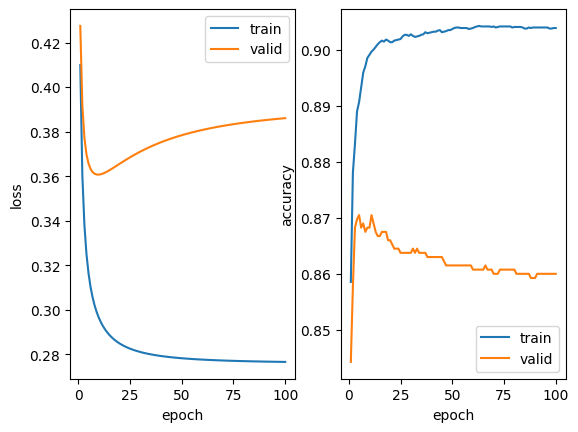

In [105]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.plot(range(1,101), losss_train, label="train")
plt.plot(range(1,101), losss_valid, label="valid")
plt.xlabel("epoch")
plt.ylabel('loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,101), accs_train, label="train")
plt.plot(range(1,101), accs_valid, label="valid")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()